In [1]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

In [2]:
def plot__real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False, figname = "figure", formato = "png"):
    
    
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    y_limits = (Y_real.min(), Y_real.max())
    plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r-.", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Comsumption", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 

In [3]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max()

(Timestamp('2014-12-31 23:00:00+0000', tz='UTC'),
 Timestamp('2018-03-14 17:00:00+0000', tz='UTC'),
 Timestamp('2018-03-14 18:00:00+0000', tz='UTC'),
 Timestamp('2018-12-31 22:00:00+0000', tz='UTC'))

# One step forecasting

## Preparación de los datasets

In [4]:
df_train

,total_generation,money_spent,hour,generation_hydro_pumped_storage_consumption,price_actual,generation_solar,generation_fossil_gas,x14_01d,x12_01n,generation_hydro_water_reservoir,...,y + 15,y + 16,y + 17,y + 18,y + 19,y + 20,y + 21,y + 22,y + 23,y + 24
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,28251.0,1847897.91,23,863.0,65.41,49.0,4844.0,0.0,1.0,1899.0,...,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0,27070.0
2015-01-01 00:00:00+00:00,27818.0,1805944.56,0,920.0,64.92,50.0,5196.0,0.0,1.0,1658.0,...,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0,27070.0,24935.0
2015-01-01 01:00:00+00:00,26796.0,1727806.08,1,1164.0,64.48,50.0,4857.0,0.0,1.0,1371.0,...,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0,27070.0,24935.0,23214.0
2015-01-01 02:00:00+00:00,25223.0,1496228.36,2,1503.0,59.32,50.0,4314.0,0.0,1.0,779.0,...,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0,27070.0,24935.0,23214.0,22540.0
2015-01-01 03:00:00+00:00,24620.0,1379704.80,3,1826.0,56.04,42.0,4130.0,0.0,1.0,720.0,...,28020.0,29014.0,29571.0,29031.0,26798.0,27070.0,24935.0,23214.0,22540.0,22096.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-14 13:00:00+00:00,34772.0,1590471.28,13,211.0,45.74,1083.0,4144.0,0.0,0.0,5220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-14 14:00:00+00:00,35734.0,1447584.34,14,1080.0,40.51,994.0,4039.0,0.0,0.0,5360.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-14 15:00:00+00:00,36030.0,1252402.80,15,1272.0,34.76,716.0,4056.0,0.0,0.0,5567.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Selecciono las columnas para one step forecasting

df_train = df_train.iloc[:,:-23].dropna()
df_test = df_test.iloc[:,:-23].dropna()

# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = scaler.fit_transform(df_train)
X_Y_test = scaler.transform(df_test)


# Hago la división en train y test

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-1], X_Y_train[:,-1],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

# Lo convierto en un problema de ML

win_len = 24             # Intento predecir el siguiente instante en el consumo con 24 h de antelación
tamaño_del_batch = 32
number_of_features = 14

# datasets

train_ts_generator = TimeseriesGenerator(X_train, Y_train, length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = 1)

val_ts_generator = TimeseriesGenerator(X_val, Y_val, length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = 1)


# length es el tamaño de la ventana
# sampling_rate es cada cuánto consideramos un dato (1 para datos continuos)
# stride es la separación entre una muestra de train y la siguiente 


print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(train_ts_generator[0][0].shape, train_ts_generator[0][1].shape)


# Para predecir varios instantes (24) de una tacada:

#X_Y_df = X_Y_df.dropna()
#
#multi_targets = X_Y_df.iloc[:,-24:].columns
#Y = X_Y_df[multi_targets[0]]
#for i in range(1,len(multi_targets)):
#    Y = pd.concat([Y, X_Y_df[multi_targets[i]]], axis = 1)
#Y = Y.to_numpy()
#Y

(21037, 14) (21037,) (7013, 14) (7013,)
(32, 24, 14) (32,)


In [14]:
df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max()

(Timestamp('2014-12-31 23:00:00+0000', tz='UTC'),
 Timestamp('2018-03-14 16:00:00+0000', tz='UTC'),
 Timestamp('2018-03-14 18:00:00+0000', tz='UTC'),
 Timestamp('2018-12-31 21:00:00+0000', tz='UTC'))

### Vemos que perdemos la útlima instancia de los sets de train y de test, consecuencia de desplazar los datos para predecir un instante en el futuro

# Establezco una medida de base con una fully connected network

In [17]:
np.random.seed(42)
tf.random.set_seed(42)


baseline_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [win_len, number_of_features]),
    keras.layers.Dense(24, activation = "relu"),
    keras.layers.Dense(1),                                                    
])

baseline_model.compile(loss = "mse",
                      optimizer = "adam", metrics = ["mse"]
                      )
history_baseline_model = baseline_model.fit(train_ts_generator, epochs = 18,
                                                     validation_data = val_ts_generator, shuffle = False)

Epoch 1/18
657/657 [==============================] - 1s 2ms/step - loss: 0.0486 - mse: 0.0486 - val_loss: 0.0189 - val_mse: 0.0189
Epoch 2/18
657/657 [==============================] - 1s 2ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 3/18
657/657 [==============================] - 1s 2ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 4/18
657/657 [==============================] - 1s 2ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 5/18
657/657 [==============================] - 1s 2ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6/18
657/657 [==============================] - 1s 1ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 7/18
657/657 [==============================] - 1s 2ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 8/18
657/657 [==============================] - 1s 2ms/step - loss: 0.

In [18]:
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 336)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 337       
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


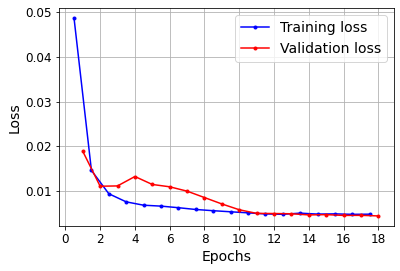

In [19]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history_baseline_model.history["loss"], history_baseline_model.history["val_loss"])
plt.show()

In [9]:
Y_train_predicted = baseline_model.predict(train_ts_generator)

df_train_predicted = pd.concat([pd.DataFrame(X_train[24:,:]), pd.DataFrame(Y_train_predicted)], axis = 1)
#train_df_predicted = train_df_predicted.set_index(df_train.index[24:])
df_train_real = pd.concat([pd.DataFrame(X_train[:,:]), pd.DataFrame(Y_train[:])], axis = 1)

X_Y_train_predicted = scaler.inverse_transform(df_train_predicted)
X_Y_train_real = scaler.inverse_transform(df_train_real)

df_train_predicted = pd.concat([pd.DataFrame(X_Y_train_predicted[:,:-1]), pd.DataFrame(X_Y_train_predicted[:, -1])], axis = 1)
df_train_real = pd.concat([pd.DataFrame(X_Y_train_real[24:,:-1]), pd.DataFrame(X_Y_train_real[24:, -1])], axis = 1)




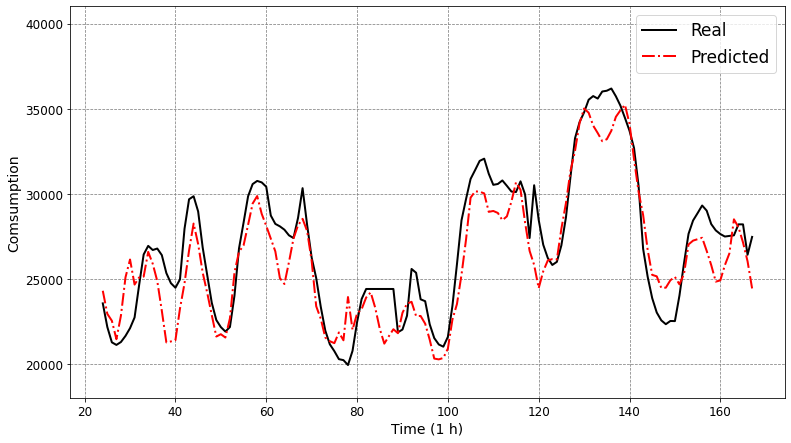

In [13]:
plot__real_vs_predicted(df_train_real.iloc[:,-1], df_train_predicted.iloc[:,-1], x_limits = (24,24*7))

### Visualizo el validation set




In [19]:
Y_val_predicted = baseline_model.predict(val_ts_generator)

df_val_predicted = pd.concat([pd.DataFrame(X_val[24:,:]), pd.DataFrame(Y_val_predicted)], axis = 1)
#train_df_predicted = train_df_predicted.set_index(df_train.index[24:])
df_val_real = pd.concat([pd.DataFrame(X_val[:,:]), pd.DataFrame(Y_val[:])], axis = 1)

X_Y_val_predicted = scaler.inverse_transform(df_val_predicted)
X_Y_val_real = scaler.inverse_transform(df_val_real)

df_val_predicted = pd.concat([pd.DataFrame(X_Y_val_predicted[:,:-1]), pd.DataFrame(X_Y_val_predicted[:, -1])], axis = 1)
df_val_real = pd.concat([pd.DataFrame(X_Y_val_real[24:,:-1]), pd.DataFrame(X_Y_val_real[24:, -1])], axis = 1)




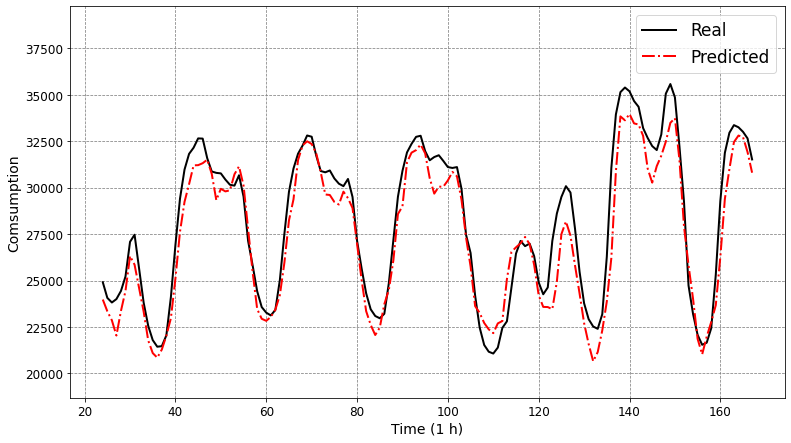

In [21]:
plot__real_vs_predicted(df_val_real.iloc[:,-1], df_val_predicted.iloc[:,-1], x_limits = (24,24*7))

# Pruebo con una RNN

# RNN 1

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

rnn_1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape=[None, 14]),
    keras.layers.SimpleRNN(20, input_shape=[None, 14]),
    keras.layers.Dense(1)
])


rnn_1.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.005))

history_rnn_1 = rnn_1.fit(train_ts_generator, epochs=20,
                    validation_data=val_ts_generator, shuffle = False)


Epoch 1/20
657/657 [==============================] - 7s 11ms/step - loss: 0.0180 - val_loss: 0.0100
Epoch 2/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 3/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 4/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 7/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 8/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 9/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 10/20
657/657 [==============================] - 7s 10ms/step - loss: 0.0024 - val_lo

In [23]:
rnn_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          700       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
_________________________________________________________________


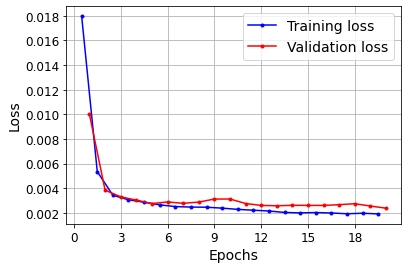

In [24]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history_rnn_1.history["loss"], history_rnn_1.history["val_loss"])
plt.show()

In [25]:
Y_train_predicted = rnn_1.predict(train_ts_generator)

df_train_predicted = pd.concat([pd.DataFrame(X_train[24:,:]), pd.DataFrame(Y_train_predicted)], axis = 1)
#train_df_predicted = train_df_predicted.set_index(df_train.index[24:])
df_train_real = pd.concat([pd.DataFrame(X_train[:,:]), pd.DataFrame(Y_train[:])], axis = 1)

X_Y_train_predicted = scaler.inverse_transform(df_train_predicted)
X_Y_train_real = scaler.inverse_transform(df_train_real)

df_train_predicted = pd.concat([pd.DataFrame(X_Y_train_predicted[:,:-1]), pd.DataFrame(X_Y_train_predicted[:, -1])], axis = 1)
df_train_real = pd.concat([pd.DataFrame(X_Y_train_real[24:,:-1]), pd.DataFrame(X_Y_train_real[24:, -1])], axis = 1)




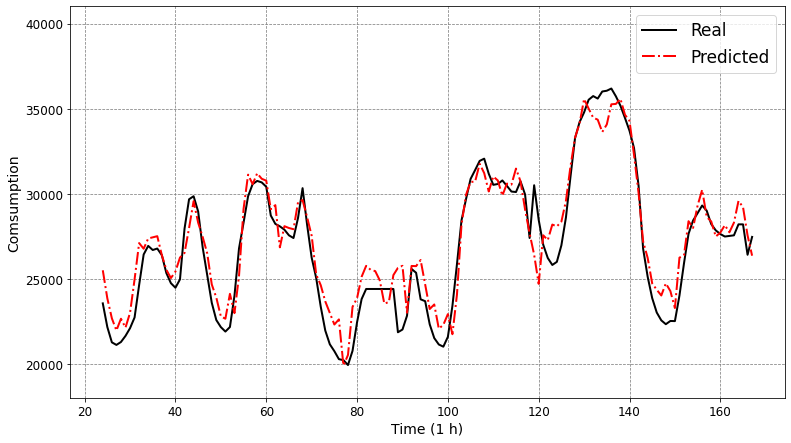

In [26]:
plot__real_vs_predicted(df_train_real.iloc[:,-1], df_train_predicted.iloc[:,-1], x_limits = (24,24*7))

### Visualizo el validation set




In [27]:
Y_val_predicted = rnn_1.predict(val_ts_generator)

df_val_predicted = pd.concat([pd.DataFrame(X_val[24:,:]), pd.DataFrame(Y_val_predicted)], axis = 1)
#train_df_predicted = train_df_predicted.set_index(df_train.index[24:])
df_val_real = pd.concat([pd.DataFrame(X_val[:,:]), pd.DataFrame(Y_val[:])], axis = 1)

X_Y_val_predicted = scaler.inverse_transform(df_val_predicted)
X_Y_val_real = scaler.inverse_transform(df_val_real)

df_val_predicted = pd.concat([pd.DataFrame(X_Y_val_predicted[:,:-1]), pd.DataFrame(X_Y_val_predicted[:, -1])], axis = 1)
df_val_real = pd.concat([pd.DataFrame(X_Y_val_real[24:,:-1]), pd.DataFrame(X_Y_val_real[24:, -1])], axis = 1)




In [28]:
df_train.iloc[:,-2].max()

41015.0

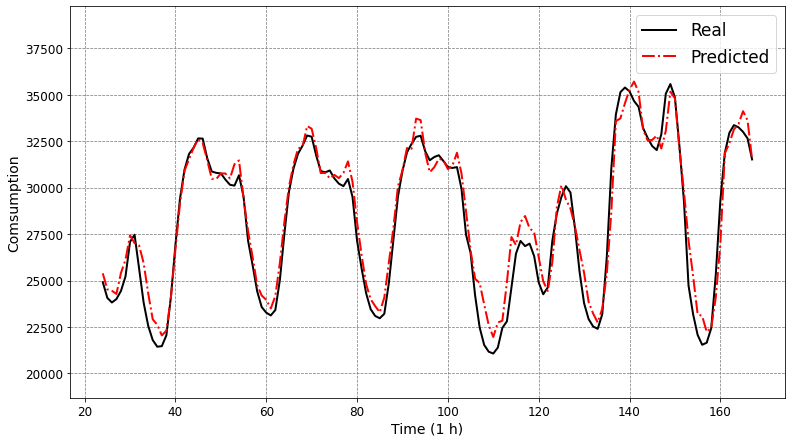

In [29]:
plot__real_vs_predicted(df_val_real.iloc[:,-1], df_val_predicted.iloc[:,-1], x_limits = (24,24*7))